In [1]:
%matplotlib inline

In [2]:
# add repo path
import sys
sys.path.append('/home/gautam_sisodia/gen-purpose-repo/')

In [3]:
import numpy as np
from functools import reduce
from tqdm import tqdm
import pandas as pd
from rl import frozenlake as fl
import matplotlib.pyplot as plt
import seaborn as sns

[2017-12-10 14:46:05,342] Making new env: FrozenLake-v0


In [4]:
import copy

In [5]:
plt.style.use('seaborn-darkgrid')

In [6]:
def get_sequences(start = 0, num_seq = 3, seq_len = 3, outer_step = 3, inner_step = 1, inner_step_change = 0):
    seqs = []
    st = start
    curr_inner_step = inner_step
    for _ in range(num_seq):
        seq = []
        entry = st
        for _ in range(seq_len):
            seq.append(entry)
            entry += curr_inner_step
        seqs.append(seq)
        st += outer_step
        curr_inner_step += inner_step_change
    return seqs

def winning_sequences():
    return get_sequences() + \
        get_sequences(outer_step = 1, inner_step = 3) + \
        get_sequences(num_seq = 2, outer_step = 2, inner_step = 4, inner_step_change = -2)
        
def check_seq(board, seq):
    return reduce(
        lambda x, y: x or y, map(
            lambda p: reduce(
                lambda x, y: x and y, map(
                    lambda x: board[x] == p, seq)), [1, 2]))

def check_win(board):
    return reduce(lambda x, y: x or y, map(lambda x: check_seq(board, x), winning_sequences()))
        
def switch_perspective(board):
    return [1 if i == 2 else 2 if i == 1 else 0 for i in board]

def print_board(board):
    return  "\n".join([" ".join(map(str, line)) for line in np.array(board).reshape(3, 3)])
        
def board_to_state(board):
    state = 0
    for ind, cell in enumerate(board):
        state += np.power(3, ind) * cell
    return state

def state_to_board(state):
    board = 9 * [0]
    pos = 0
    while state > 0 and pos < 9:
        state, board[pos] = divmod(state, 3)
        pos += 1
    return board

def board_string(board):
    return "\n".join([" ".join(map(str, line)) for line in np.array(board).reshape(3, 3)])

In [7]:
def count_num_pieces(board, player):
    return len([i for i in board if i == player])

def valid(board, player):
    return not check_win(board) and count_num_pieces(board, 1) == count_num_pieces(board, 2) + player - 1

def moves_to_win(board, player):
    winning_moves = []
    for i in range(9):
        if board[i] == 0:
            next_board = copy.deepcopy(board)
            next_board[i] = player
            if check_win(next_board):
                winning_moves.append(i)
    return winning_moves

def get_one_move_away_states():
    one_move_away_states = {p: {} for p in ["player1", "player2"]}
    for state in tqdm(range(np.power(3, 9))):
        board = state_to_board(state)
        for player in [1, 2]:
            if valid(board, player):
                moves_list = moves_to_win(board, player)
                if len(moves_list) > 0:
                    one_move_away_states["player{}".format(player)][state] = moves_list
    return one_move_away_states

def is_oma(current_game_action_num, current_state):
    player = 2 - current_game_action_num % 2
    return current_state in oma_states["player{}".format(player)].keys() 

def made_oma_move(oma, current_game_action_num, action, current_state):
    player = 2 - current_game_action_num % 2
    return oma and action in oma_states["player{}".format(player)][current_state]

In [8]:
oma_states = get_one_move_away_states()

100%|██████████| 19683/19683 [00:02<00:00, 7161.34it/s]


In [9]:
class Strategy():
    def __init__(self, pick_action, update_strategy):
        self.pick_action = pick_action
        self.update_strategy = update_strategy        
        
class TicTacToe(object):
    def __init__(self):
        self.board = 9 * [0]
        self.num_moves = 0
        self.game_end = False
        self.winning_sequences = winning_sequences()
                    
    def get_player(self):
        return self.num_moves % 2 + 1
        
    def step(self, action):
        reward = 0
        if action >= 0 and action <= 9:
            position = self.board[action]
            if position == 0:
                self.board[action] = self.get_player()
                if self.check_win():
                    reward = 1 if self.get_player() == 1 else -1
                    self.game_end = True
                if self.check_cats_game():
                    self.game_end = True
            # else:
            #     reward = -1
        self.num_moves += 1
        return reward
    
    def check_cats_game(self):
        return len([i for i in self.board if i == 0]) == 0
                
    def check_win(self):
        return check_win(self.board)
        
    def switch_perspective(self):
        return [1 if i == 2 else 2 if i == 1 else 0 for i in self.board]
    
    def render(self, print_string = True):
        board_string = "\n".join([" ".join(map(str, line)) for line in np.array(self.board).reshape(3, 3)] +\
            ["player {}'s move".format(self.get_player()) if not self.game_end else "game over"])
        if print_string:
            print(board_string)
        return board_string

In [10]:
def rand_pick_action(current_state, current_game, rev = False):
    return np.random.choice(range(9))

def rand_update_strategy(current_state, action, next_state, reward, game_end):
    pass

rand_strategy = Strategy(rand_pick_action, rand_update_strategy)

In [11]:
def human_pick_action(current_state, current_game, rev = False):
    return int(input(print_board(state_to_board(current_state))))

def human_update_strategy(current_state, action, next_state, reward, game_end):
    pass

human_strategy = Strategy(human_pick_action, human_update_strategy)

In [39]:
def play_game(strategies, game_num = 10000):
    game = TicTacToe()
    game_end = False
    current_game_action_num = 1
    game_string = ""
    while not game_end and current_game_action_num < 20:
        current_state = board_to_state(game.board)
        # move
        player = (current_game_action_num - 1) % 2
        print("player: {}".format(player))
        player_perspective_state = current_state # if player == 0 else board_to_state(game.switch_perspective())
        strategy = strategies[player] if len(strategies) == 2 else strategies[0]
        action = strategy.pick_action(player_perspective_state, game_num, rev = player == 1)
        game.step(action)
        game_end = game.game_end
        current_game_action_num += 1
        game_string += game.render() + "\n"
    return game_string

In [40]:
def run_n_games(num_games, strategies, current_info_dict = False, use_tqdm = True, update = True):
    states_info_dict = {
        "current_game": [],
        "current_game_action_num": [],
        "current_state": [],
        "current_state_perspective": [],
        "action": [],
        "next_state": [],
        "next_state_perspective": [],
        "oma": [],
        "oma_move": [],
        "reward": [],
        "end_game": []
    } if current_info_dict == False else current_info_dict

    prev_games_played = 0 if current_info_dict == False else len(set(current_info_dict["current_game"]))
    
    loop_list = tqdm(range(1, num_games + 1)) if use_tqdm else range(1, num_games + 1)

    # run the games
    for game_num in loop_list:
        game = TicTacToe()
        game_end = False
        current_state = board_to_state(game.board)
        current_game_action_num = 1
        while not game_end:
            reward = [0, 0]
            # move
            player = (current_game_action_num - 1) % 2
            player_perspective_state = current_state # if player == 0 else board_to_state(game.switch_perspective())
            strategy = strategies[player] if len(strategies) == 2 else strategies[0]
            action = strategy.pick_action(player_perspective_state, game_num + prev_games_played, rev = player == 1)
            reward[player] = game.step(action)
            next_state = board_to_state(game.board)
            game_end = game.game_end
            if update:
                strategy.update_strategy(current_state, action, next_state, reward[player], game_end)

            # add info to dict
            states_info_dict["current_game"].append(game_num + prev_games_played)
            states_info_dict["current_game_action_num"].append(current_game_action_num)
            states_info_dict["current_state"].append(current_state)
            states_info_dict["current_state_perspective"].append(player_perspective_state)            
            states_info_dict["action"].append(action)
            states_info_dict["next_state"].append(next_state)
            states_info_dict["next_state_perspective"].append(next_state if player == 0 else board_to_state(game.switch_perspective()))
            states_info_dict["reward"].append(reward)
            states_info_dict["end_game"].append(game_end)
            
            oma = is_oma(current_game_action_num, current_state)
            
            states_info_dict["oma"].append(oma)
            states_info_dict["oma_move"].append(made_oma_move(oma, current_game_action_num, action, current_state))


            # update info
            current_state = next_state
            current_game_action_num += 1

    game_df = pd.DataFrame(states_info_dict)
    # add_state_row_column(game_df, ["current_state", "next_state"])
    return states_info_dict, game_df

def print_game_stats(game_df):
    num_games = max(game_df.current_game)

    # total number of moves?
    print("Total number of moves: {}\nNumber of moves per game: {}".format(
        len(game_df),
        1.0 * len(game_df) / num_games))

    # winning percentage?
    num_games_won = reduce(lambda x, y: np.array(x) + np.array(y), game_df[game_df.end_game].reward)
    print(
        "Total number of games won by player 1: {}\nTotal number of games won by player 2: {}\nPercentage of games won: {}".format(
            num_games_won[0],
            num_games_won[1],
            100.0 * num_games_won.sum() / num_games))

In [41]:
class TicTacToeQTable(Strategy):
    
    def __init__(self, gamma = 0.95, learning_rate = 0.9, damper = 0.0001, rand_rate = 0.5):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.q_table = np.random.rand(np.power(3, 9), 9) * damper
        self.rand_rate = rand_rate
        
    def pick_action(self, current_state, current_game, rev = False):
        mult = -1 if rev else 1
        return np.argmax(mult * self.q_table[current_state,:] + np.random.randn(1, 9) * (1.0 / (self.rand_rate * current_game + 1)))

    def update_strategy(self, current_state, action, next_state, reward, game_end):
        self.q_table[current_state, action] = self.q_table[current_state, action] -\
          self.learning_rate * (self.q_table[current_state, action] - reward - self.gamma * np.max(self.q_table[next_state, :]))


In [42]:
def plot_cats_games(games_df, window = 100):
    games_df["ttl_reward"] = games_df.reward.map(lambda x: x[0] + x[1])
    end_games = games_df[games_df.end_game]
    end_games["cats_game"] = end_games.ttl_reward.map(lambda x: x == 0)
    cats_games_rolling_avg = end_games[["cats_game"]].rolling(window).mean()
    fig, ax = plt.subplots(figsize = (20, 6))
    ax.plot(cats_games_rolling_avg.index, cats_games_rolling_avg.cats_game)
    
def plot_oma(games_df):
    oma = games_df[games_df.oma]
    oma["player"] = 2 - oma.current_game_action_num % 2
    omas = [oma[oma.player == p] for p in [1, 2]]
    fig, ax = plt.subplots(figsize = (20, 6))
    for p in [0, 1]:
        omas[p]["oma_cumsum"] = omas[p].oma.cumsum()
        omas[p]["oma_move_cumsum"] = omas[p].oma_move.cumsum()
        omas[p]["oma_pcnt"] = omas[p].apply(lambda x: 0 if x.oma_cumsum == 0 else x.oma_move_cumsum / x.oma_cumsum, axis = 1)
        ax.plot(omas[p].index, omas[p].oma_pcnt, label = "player {}".format(p + 1))
    ax.legend()

In [43]:
def get_most_common_states(games_df):
    return [
        {"board": state_to_board(b), "name": ""}
        for b in games_df.groupby("current_state_perspective").count().sort_values("action", ascending = False).index[:5]]

def draw_heatmap(qtable, board, ax, title = "", norm = False, cbar = True):
    state = board_to_state(board)
    mat = qtable.q_table[state].reshape(3, 3)
    if norm:
        mat = (mat - np.min(mat)) / (np.max(mat) - np.min(mat))
    
    sns.heatmap(
        mat,
        vmin = 0 if norm else np.min(qtable.q_table),
        vmax = 1 if norm else np.max(qtable.q_table),
        annot = np.array(state_to_board(state)).reshape(3, 3),
        cmap = sns.cubehelix_palette(10) if norm else sns.color_palette("coolwarm_r", 7),
        cbar = cbar,
        ax = ax,
        square = True,
        linewidths = 0.1,
        xticklabels = False,
        yticklabels = False)
    
    ax.set_title(title)
    
    
def plot_states(qtable,some_states):
    fig, ax = plt.subplots(figsize = (25, 10), nrows = 2, ncols = len(some_states))
    for ind, some_state in enumerate(some_states):
        draw_heatmap(qtable, some_state["board"], ax[0][ind], some_state["name"] + " (raw)", norm = False, cbar = False)
        draw_heatmap(qtable, some_state["board"], ax[1][ind], some_state["name"] + " (norm)", norm = True, cbar = False)

def plot_most_common_states(qtable, games_df):
    most_common_states = get_most_common_states(games_df)
    plot_states(qtable, most_common_states)

In [17]:
game = TicTacToe()

In [18]:
game.render()

0 0 0
0 0 0
0 0 0
player 1's move


"0 0 0\n0 0 0\n0 0 0\nplayer 1's move"

In [19]:
game.step(1)
board_to_state(game.board)

3

In [20]:
game.step(0)
game.step(1)
game.step(3)
game.step(2)
game.step(6)

-1

In [21]:
game.render()

2 1 1
2 0 0
2 0 0
game over


'2 1 1\n2 0 0\n2 0 0\ngame over'

In [22]:
game.check_win()

True

In [23]:
rand_games_df = run_n_games(num_games = 10000, strategies = [rand_strategy], use_tqdm = True)[1]

100%|██████████| 10000/10000 [00:13<00:00, 752.38it/s]


In [24]:
print_game_stats(rand_games_df)

Total number of moves: 150333
Number of moves per game: 15.0333
Total number of games won by player 1: 5427
Total number of games won by player 2: -3825
Percentage of games won: 16.02


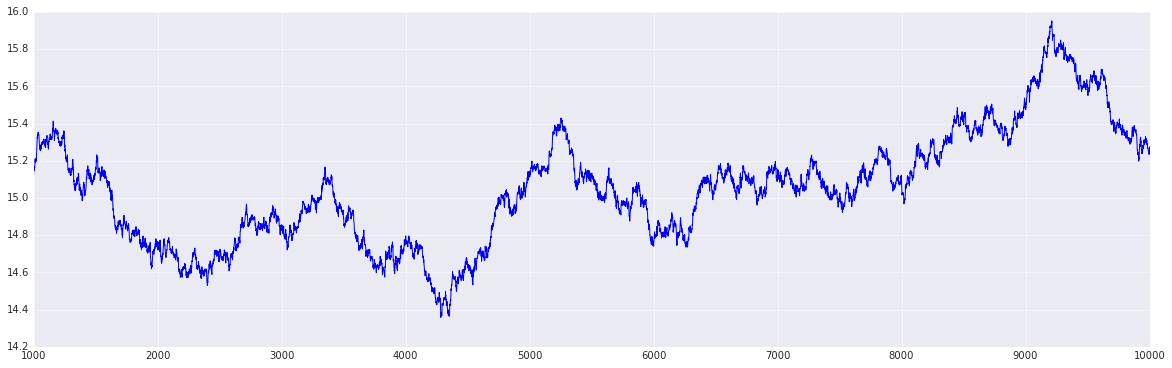

In [25]:
fl.plot_game_length(rand_games_df, 1000)

/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


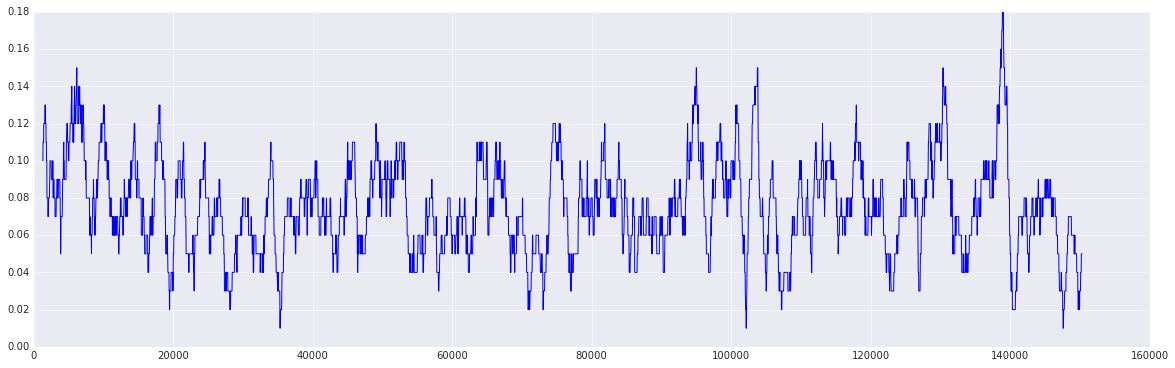

In [26]:
plot_cats_games(rand_games_df)

/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

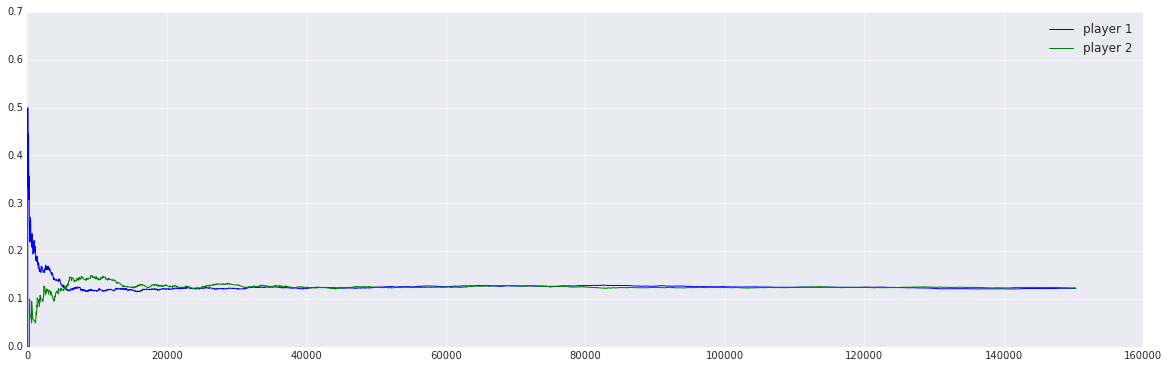

In [27]:
plot_oma(rand_games_df)

## Q Table

In [28]:
qtable = TicTacToeQTable()

In [29]:
some_states = [
    {"board": [0, 0, 0, 0, 0, 0, 0, 0, 0], "name": "opening"},
    {"board": [1, 1, 0, 0, 2, 0, 0, 0, 2], "name": "attack 1"},
    {"board": [1, 1, 0, 2, 0, 0, 0, 0, 2], "name": "attack 2"},
    {"board": [2, 2, 0, 0, 1, 0, 0, 0, 1], "name": "defense 1"},
    {"board": [2, 2, 0, 0, 1, 0, 0, 0, 1], "name": "defense 2"}
]

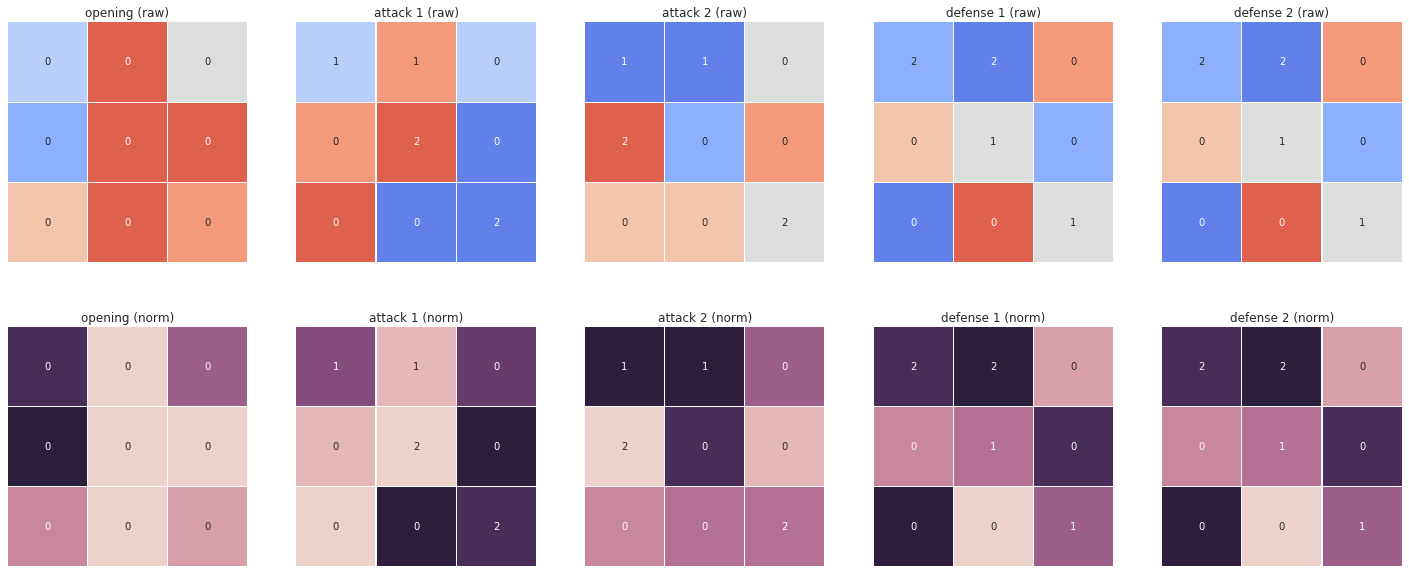

In [30]:
plot_states(qtable, some_states)

In [44]:
info_dict = False

100%|██████████| 10000/10000 [00:08<00:00, 1119.68it/s]


Total number of moves: 79200
Number of moves per game: 7.92
Total number of games won by player 1: 47
Total number of games won by player 2: -9949
Percentage of games won: -99.02


/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

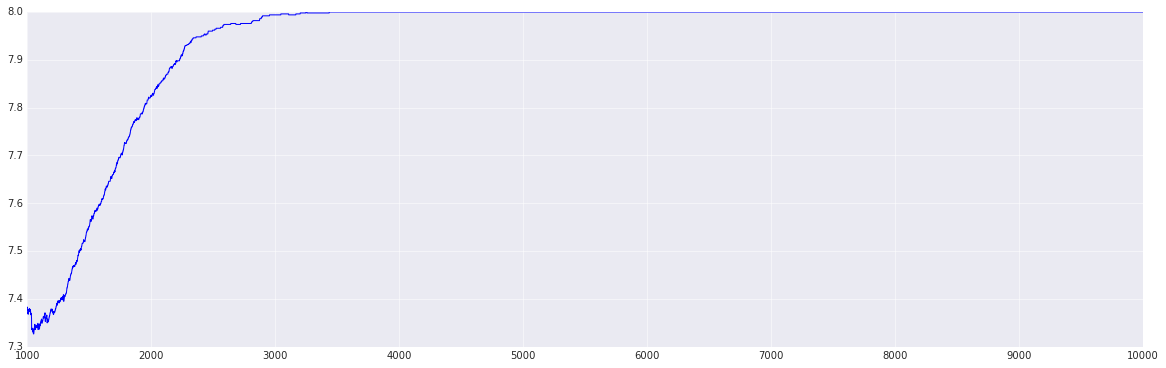

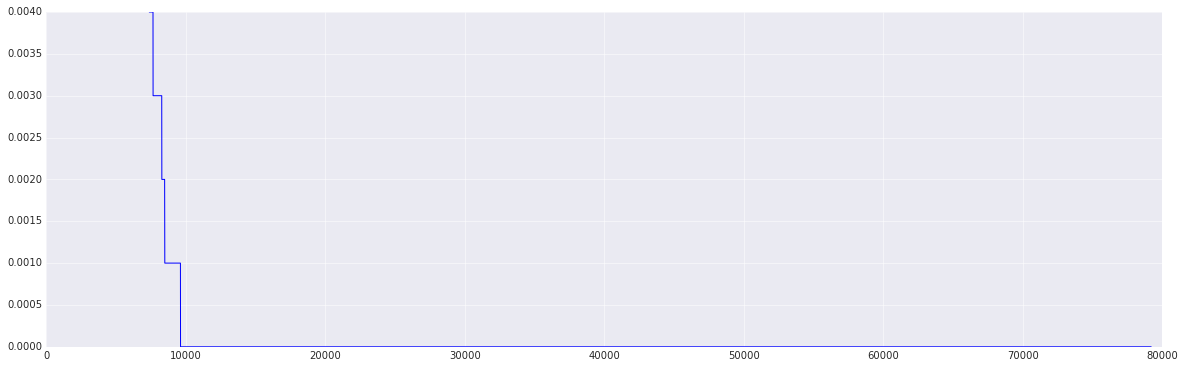

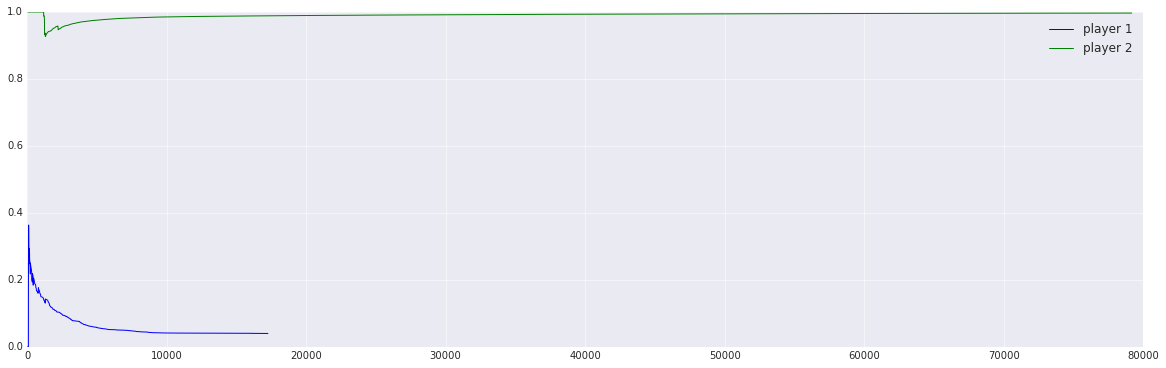

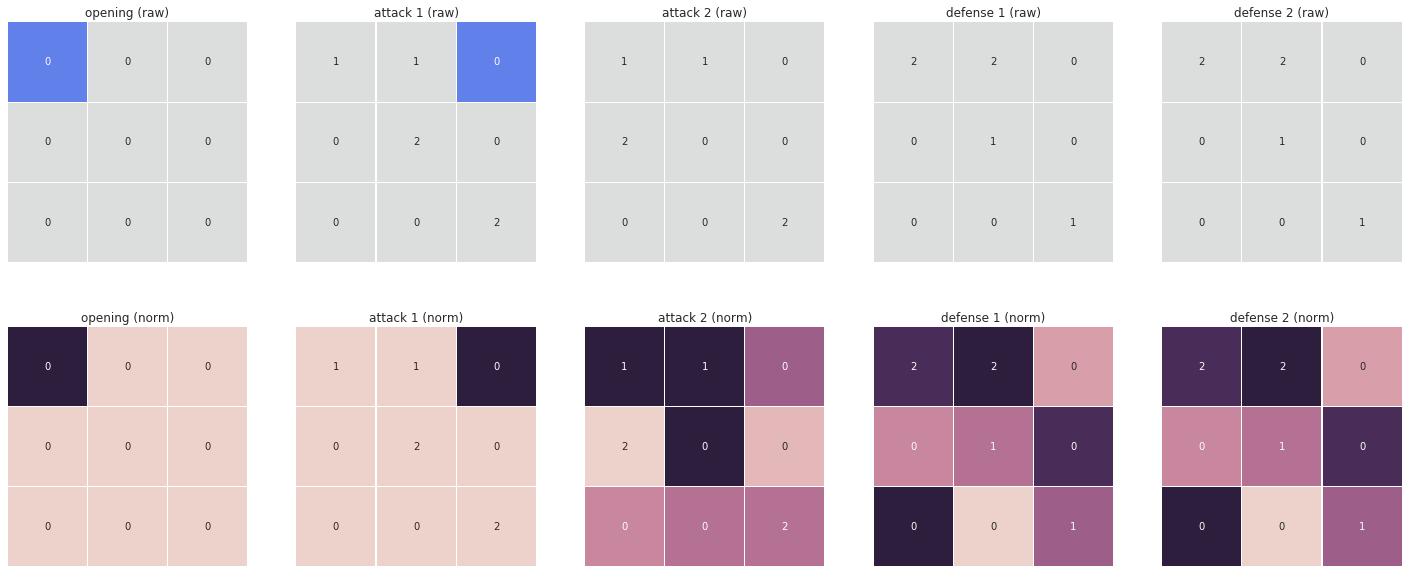

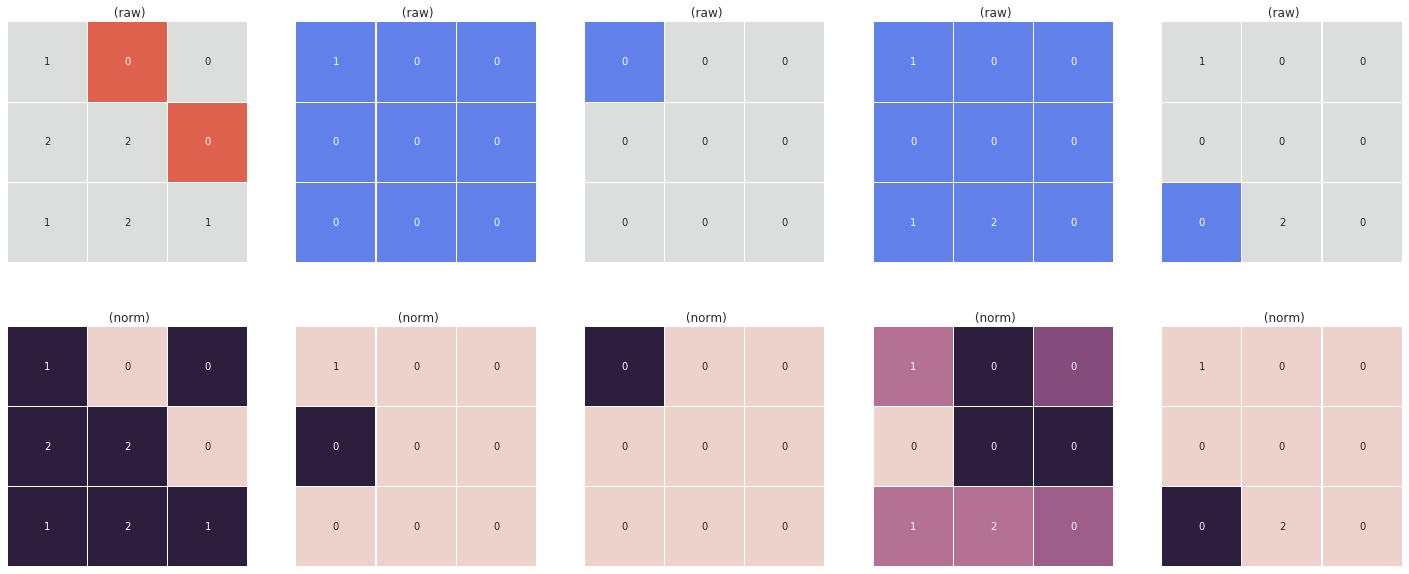

In [45]:
info_dict, qtable_games_df = run_n_games(num_games = 10000, current_info_dict = info_dict, strategies = [qtable], use_tqdm = True)
print_game_stats(qtable_games_df)
fl.plot_game_length(qtable_games_df, 1000)
plot_cats_games(qtable_games_df, 1000)
plot_oma(qtable_games_df)
plot_states(qtable, some_states)
plot_most_common_states(qtable, qtable_games_df)

100%|██████████| 10000/10000 [00:08<00:00, 1187.86it/s]


Total number of moves: 852758
Number of moves per game: 7.752345454545455
Total number of games won by player 1: 53163
Total number of games won by player 2: -56251
Percentage of games won: -2.807272727272727


/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

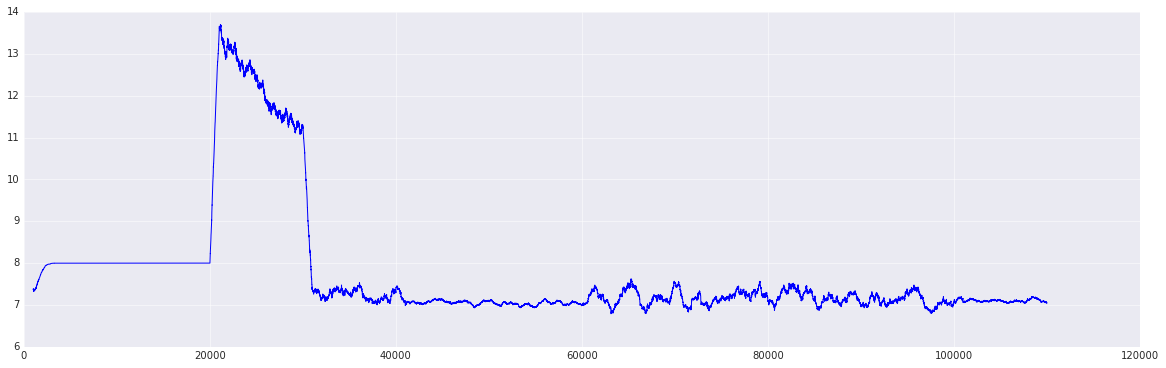

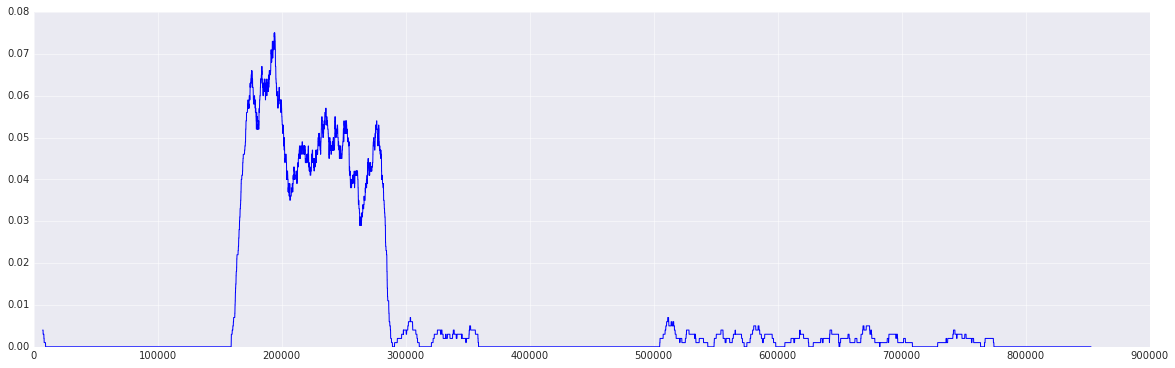

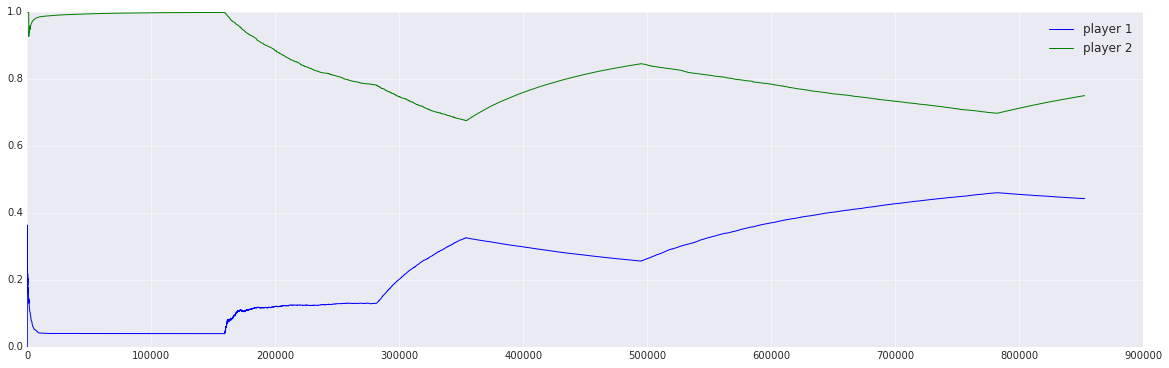

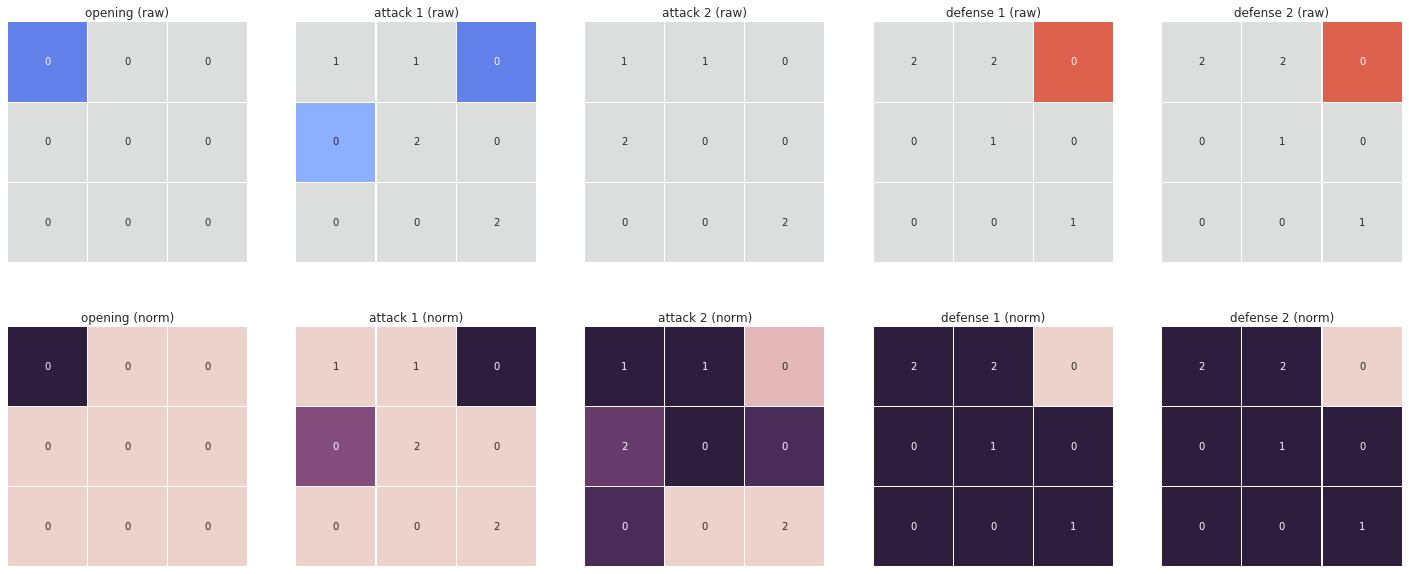

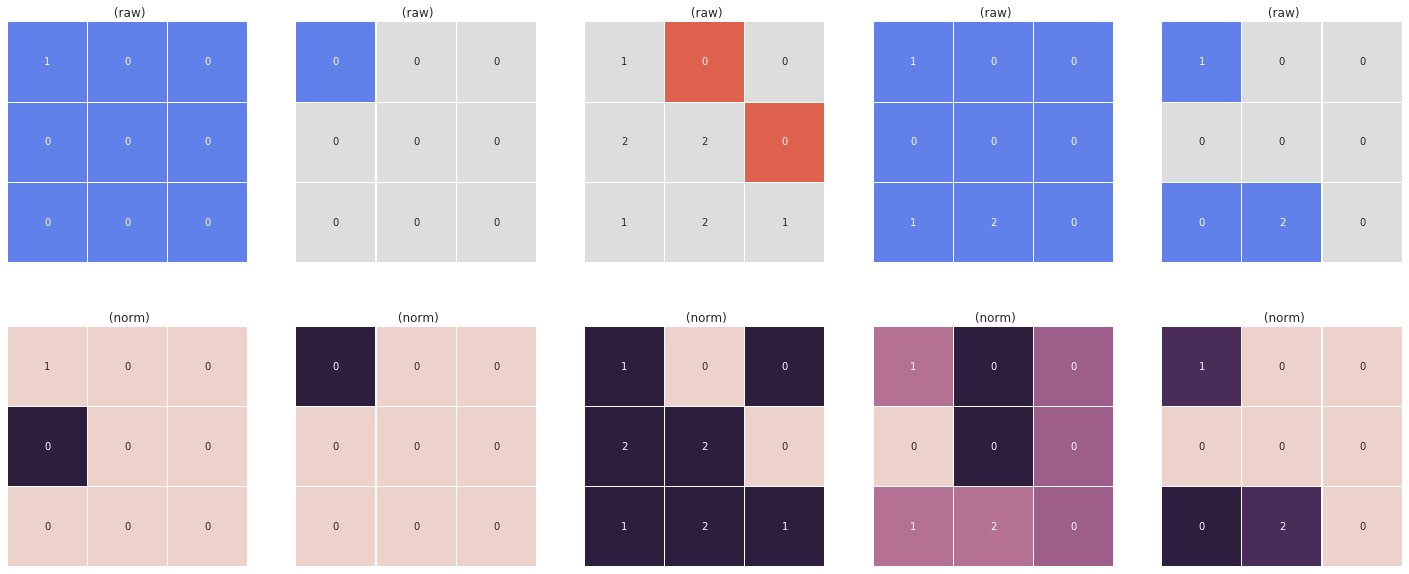

In [55]:
info_dict, qtable_games_df = run_n_games(num_games = 10000, current_info_dict = info_dict, strategies = [qtable], use_tqdm = True)
print_game_stats(qtable_games_df)
fl.plot_game_length(qtable_games_df, 1000)
plot_cats_games(qtable_games_df, 1000)
plot_oma(qtable_games_df)
plot_states(qtable, some_states)
plot_most_common_states(qtable, qtable_games_df)

In [110]:
max_game_num = qtable_games_df.current_game.max()
qtable_games_df[qtable_games_df.current_game > max_game_num - 3]

,action,current_game,current_game_action_num,current_state,current_state_perspective,end_game,next_state,next_state_perspective,reward,ttl_reward
660469,4,79998,1,0,0,False,81,81,"[0, 0]",0
660470,7,79998,2,81,162,False,4455,2349,"[0, 0]",0
660471,5,79998,3,4455,4455,False,4698,4698,"[0, 0]",0
660472,2,79998,4,4698,2835,False,4716,2844,"[0, 0]",0
660473,3,79998,5,4716,4716,True,4743,4743,"[1, 0]",1
660474,4,79999,1,0,0,False,81,81,"[0, 0]",0
660475,2,79999,2,81,162,False,99,171,"[0, 0]",0
660476,8,79999,3,99,99,False,6660,6660,"[0, 0]",0
660477,5,79999,4,6660,13293,False,7146,13536,"[0, 0]",0
660478,0,79999,5,7146,7146,True,7147,7147,"[1, 0]",1


In [111]:
qtable.q_table[162]

array([  1.10900652e-06,   6.45483467e-05,   9.77938528e-05,
         2.58282315e-05,   6.27874782e-05,   2.00970244e-05,
         3.70937733e-05,   8.86986857e-05,   8.41923893e-05])

In [105]:
game_string = play_game(strategies = [qtable], game_num = 1000000)

player: 0
0 0 0
0 1 0
0 0 0
player 2's move
player: 1
0 0 2
0 1 0
0 0 0
player 1's move
player: 0
0 0 2
0 1 1
0 0 0
player 2's move
player: 1
0 2 2
0 1 1
0 0 0
player 1's move
player: 0
1 2 2
0 1 1
0 0 0
player 2's move
player: 1
1 2 2
0 1 1
2 0 0
player 1's move
player: 0
1 2 2
0 1 1
2 1 0
player 2's move
player: 1
1 2 2
0 1 1
2 1 2
player 1's move
player: 0
1 2 2
1 1 1
2 1 2
game over


In [50]:
play_game(strategies = [qtable, human_strategy])

player: 0
0 0 0
0 0 0
0 0 1
player 2's move
player: 1
0 0 0
0 0 0
0 0 24
0 0 0
0 2 0
0 0 1
player 1's move
player: 0
0 0 1
0 2 0
0 0 1
player 2's move
player: 1
0 0 2
0 1 0
0 0 25
0 0 1
0 2 2
0 0 1
player 1's move
player: 0
0 0 1
1 2 2
0 0 1
player 2's move
player: 1
0 0 2
2 1 1
0 0 27
0 0 1
1 2 2
0 2 1
player 1's move
player: 0
1 0 1
1 2 2
0 2 1
player 2's move
player: 1
2 0 2
2 1 1
0 1 21
1 2 1
1 2 2
0 2 1
game over


"0 0 0\n0 0 0\n0 0 1\nplayer 2's move\n0 0 0\n0 2 0\n0 0 1\nplayer 1's move\n0 0 1\n0 2 0\n0 0 1\nplayer 2's move\n0 0 1\n0 2 2\n0 0 1\nplayer 1's move\n0 0 1\n1 2 2\n0 0 1\nplayer 2's move\n0 0 1\n1 2 2\n0 2 1\nplayer 1's move\n1 0 1\n1 2 2\n0 2 1\nplayer 2's move\n1 2 1\n1 2 2\n0 2 1\ngame over\n"